# Wavelets

### Import

In [14]:
import numpy as np
import pandas as pd
from pathlib import Path 
import datatable as dt

import pywt
import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import Dense
from keras import Input, Model

### Get data

In [2]:
filepath = Path('../../data/csv/crypto_market_data.csv')

In [3]:
df_crypto = dt.fread(filepath).to_pandas() 
df_crypto = df_crypto.T.set_index([0, 1]).T
df_crypto = df_crypto.set_index('')
df_crypto = df_crypto.astype(float)
df_crypto.index.names = ['date']

df_btc = df_crypto['BTC-USD']['Close']
df_btc.head(3)

date
2020-04-07 00:00:00+00:00    7366.915527
2020-04-07 01:00:00+00:00    7355.732910
2020-04-07 02:00:00+00:00    7311.450195
Name: Close, dtype: float64

In [4]:
# df_btc_retrun = df_btc.pct_change().dropna()
#df_btc_retrun.head(3)

### Compute signals

In [5]:
df_signals = pd.DataFrame([])

#### 1. Wavelet smoothing

In [6]:
def wavelet_smoothing(df, wavelet="db6", scale = 0.5): # scale = 0.5   
    coeff = pywt.wavedec(df, wavelet, mode='per', level=None)
    coeff[1:] = [pywt.threshold(i, value=scale*df.max(), mode='soft') for i in coeff[1:]]
    
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode='per')
    return pd.Series(reconstructed_signal).tail(1).values[0]

In [7]:
df_signals['wavelet_smoothing'] = df_btc.rolling(window=1000, min_periods=100).apply(lambda x: wavelet_smoothing(x))
df_signals['wavelet_clf'] = df_signals.copy().join(df_btc).apply(lambda row: 1*(row.wavelet_smoothing < row.Close), axis=1)

In [8]:
df_signals = df_signals.dropna()
df_signals.head(3)

,wavelet_smoothing,wavelet_clf
date,,
2020-04-11 04:00:00+00:00,7113.095232,0
2020-04-11 05:00:00+00:00,7113.466363,0
2020-04-11 06:00:00+00:00,7112.908368,0


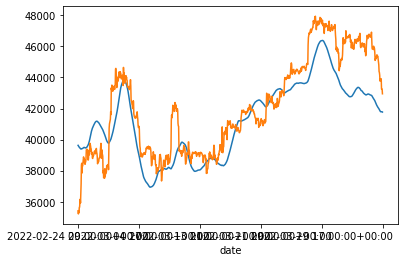

In [9]:
df_signals.wavelet_smoothing.tail(1000).plot()
df_btc.tail(1000).plot()

#### 2. Wavelet decomposition

In [10]:
def wavelet_decomposition(df, wavelet="db6", scale = 0.1): # scale = 0.5    
    coeff = pywt.wavedec(df, wavelet, mode='per')
    coeff[1:] = [pywt.threshold(i, value=scale*df.max(), mode='soft') for i in coeff[1:]]
    return coeff

In [11]:
df_wavelet_decomposition = pd.DataFrame([])

Next steps:
- build dataset of coefficients at each timestemps
- reduce size using autoencoder model

### Save signals

In [12]:
filepath = Path('../csv/signals_wavelets.csv')

In [13]:
df_signals.to_csv(filepath)